In [1]:
import os
print(os.listdir("/kaggle/input"))

['state-farm-distracted-driver-detection']


In [2]:
import os
import shutil
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Class names for labels
state = [
    'safe driving', 'texting - right', 'talking on the phone - right', 
    'texting - left', 'talking on the phone - left', 'operating the radio', 
    'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger', 'UNKNOWN'
]

## Data Directory

In [4]:
# Dataset paths
source_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
driver_csv = '/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
train_dir = '/kaggle/working/train_images'
test_dir = '/kaggle/working/test_images'

# Prepare dataset by splitting into 80-20 train-test split
def prepare_dataset():
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            images = [img for img in images if os.path.isfile(os.path.join(class_dir, img))]

            # Train-test split
            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for img in train_images:
                shutil.copy2(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
            for img in test_images:
                shutil.copy2(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

    print("80-20 train-test split completed.")

prepare_dataset()

80-20 train-test split completed.


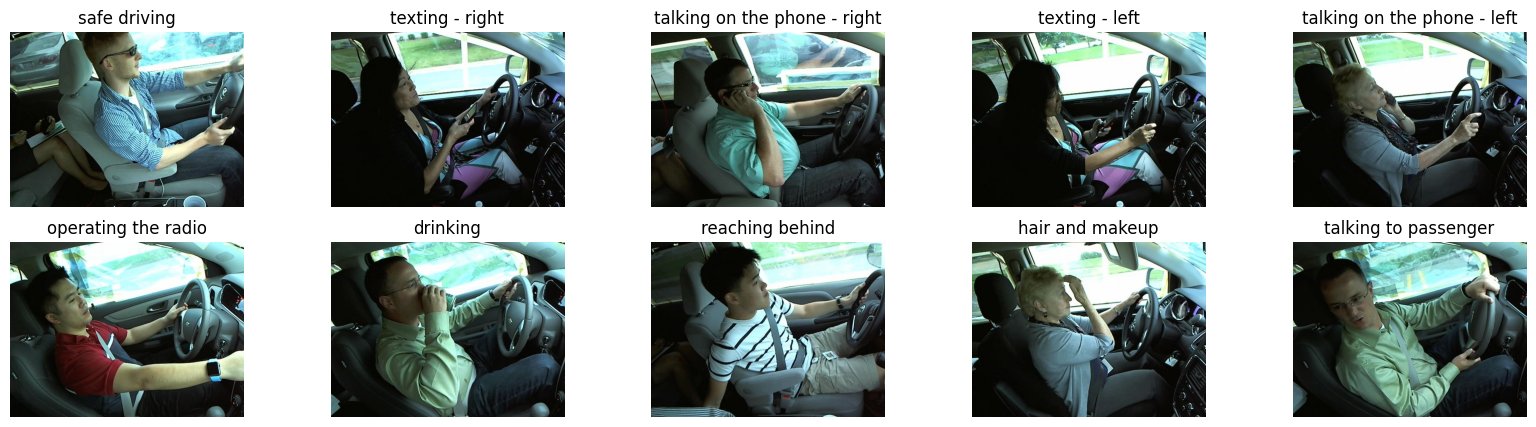

In [5]:
# Visualization function
def display_sample_images():
    def display(path, class_idx=None):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if class_idx is None:
            plt.figure()
            plt.title(state[10])
            plt.imshow(img)
            plt.axis("off")
        else:
            plt.subplot(2, 5, class_idx + 1)
            plt.title(state[class_idx])
            plt.imshow(img)
            plt.axis("off")

    plt.figure(figsize=(20, 5))
    display(f"{source_dir}/c0/img_100026.jpg", 0)
    display(f"{source_dir}/c1/img_100021.jpg", 1)
    display(f"{source_dir}/c2/img_100029.jpg", 2)
    display(f"{source_dir}/c3/img_100006.jpg", 3)
    display(f"{source_dir}/c4/img_100225.jpg", 4)
    display(f"{source_dir}/c5/img_10000.jpg", 5)
    display(f"{source_dir}/c6/img_100036.jpg", 6)
    display(f"{source_dir}/c7/img_100057.jpg", 7)
    display(f"{source_dir}/c8/img_100015.jpg", 8)
    display(f"{source_dir}/c9/img_100090.jpg", 9)
    plt.show()

display_sample_images()

## Data Preparation

In [6]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


from torch.utils.data import random_split

def create_dataloaders(train_dir, test_dir, transform, batch_size=32, val_split=0.2):
    """
    Create DataLoaders for training, validation, and testing.

    Args:
        train_dir (str): Path to the training directory.
        test_dir (str): Path to the testing directory.
        transform (torchvision.transforms.Compose): Transformations to apply to the data.
        batch_size (int): Batch size for the DataLoader.
        val_split (float): Proportion of training data to use for validation (default: 0.2).

    Returns:
        tuple: train_loader, val_loader, test_loader
    """
    # Load the train dataset
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    
    # Split into train and validation datasets
    train_size = int((1 - val_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data = random_split(train_dataset, [train_size, val_size])
    
    # Create DataLoaders for train and validation datasets
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Load the test dataset
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train dataset size: {len(train_data)}")
    print(f"Validation dataset size: {len(val_data)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader


# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(train_dir, test_dir, transform, batch_size=32, val_split=0.2)

Train dataset size: 14347
Validation dataset size: 3587
Test dataset size: 4490


# Custom CNN Model : 

This model features:
* Three convolutional layers with decreasing filter sizes (128 → 64 → 32)
* Smaller feature map size (6x6) in the final layer
* Three fully connected layers (1024 → 256 → 10)10)

In [7]:
class CNNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=32*26*26, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=10)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        
        # Dynamically compute the flattened dimensions
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        return self.out(x)


torch.manual_seed(42)

model = CNNmodel()
model.to(device)
model

CNNmodel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

# Transfer Learning Models
## ResNet101 Strategy 1 : Feature Extractor
Features: 
* Uses pre-trained ResNet101
* All original layers frozen (not trainable)
* Only the final classification layer is trained
* Acts as a pure feature extractorctor

In [8]:
def resnet_strategy_1():
    model = models.resnet101(pretrained = True)
    # Freeze all layers by setting requires_grad to False
    # This prevents the weights from being updated during training
    for param in model.parameters():
        param.requires_grad = False
    # Replace the final fully connected layer (fc) with a new one
    # in_features: maintains the original input size from ResNet
    # out_features: 10 represents the number of classes in our new task
    model.fc = nn.Linear(model.fc.in_features, 10)
     # Return the modified ResNet model
    return model

## ResNet101 Strategy 2 : Fine Tunining
Features : 
* Uses pre-trained ResNet101
* Unfreezes the last convolutional block (layer4)
* Allows fine-tuning of deeper layers
* Better adaptation to new tasks while maintaining learned features

In [9]:
def resnet_strategy_2():
    model = models.resnet101(pretrained=True)
    # Iterate through all named layers and their parameters in the model
    # name: identifies the layer (e.g., 'layer4.0.conv1', 'fc')
    # param: contains the actual parameters (weights and biases) of that layer
    for name, param in model.named_parameters():
        # Check if the current layer is either the last conv block (layer4) or final FC layer
        # layer4: the deepest convolutional block in ResNet101
        # fc: the final fully connected classification layer
        if "layer4" in name or "fc" in name:
             # Enable gradient computation for these layers
            # This allows these layers to be fine-tuned during training
            param.requires_grad = True
        else:
            param.requires_grad = False
    # Replace the final fully connected layer
    # model.fc.in_features: number of input features from the previous layer
    # 10: number of output classes for our specific task
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

## Training Function

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    # Set device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move model to the selected device
    model.to(device)

    # Store loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Loop through specified number of epochs
    for epoch in range(num_epochs):
        # Set model to training mode (enables dropout, batch norm, etc.)
        model.train()
        running_loss = 0.0
        
        # Training phase
        for inputs, labels in train_loader:
            # Move input data and labels to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients to prevent accumulation
            optimizer.zero_grad()
            
            # Forward pass: compute model predictions
            outputs = model(inputs)
            
            # Calculate loss between predictions and actual labels
            loss = criterion(outputs, labels)
            
            # Backward pass: compute gradient of the loss
            loss.backward()

            # Update model parameters based on computed gradients
            optimizer.step()

            # Accumulate loss for this batch
            running_loss += loss.item() * inputs.size(0)
            
        train_losses.append(running_loss / len(train_loader.dataset))

        # Validation phase
        val_loss = 0.0
        correct = 0 # Counter for correct prediction
        total = 0 # Counter for total prediction

        # Set model to evaluation mode (disable dropout, batch norm, etc)
        model.eval()

        # Disable graident computation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move validation data to device
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass on validation data
                outputs = model(inputs)
                
                # Calculate validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                # Get predictions by selecting highest probability class
                _, preds = torch.max(outputs, 1)
                
                # Count correct predictions
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

## Testing Function

In [11]:
def test_model_with_metrics(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes,
                yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


## Visualize the results

In [12]:
def plot_training_results(train_losses, val_losses, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title(f"{model_name} - Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Epoch 1/5, Train Loss: 0.6006, Val Loss: 0.1864, Accuracy: 0.9448
Epoch 2/5, Train Loss: 0.0692, Val Loss: 0.0809, Accuracy: 0.9766
Epoch 3/5, Train Loss: 0.0325, Val Loss: 0.0772, Accuracy: 0.9785
Epoch 4/5, Train Loss: 0.0242, Val Loss: 0.0542, Accuracy: 0.9866
Epoch 5/5, Train Loss: 0.0347, Val Loss: 0.0607, Accuracy: 0.9858


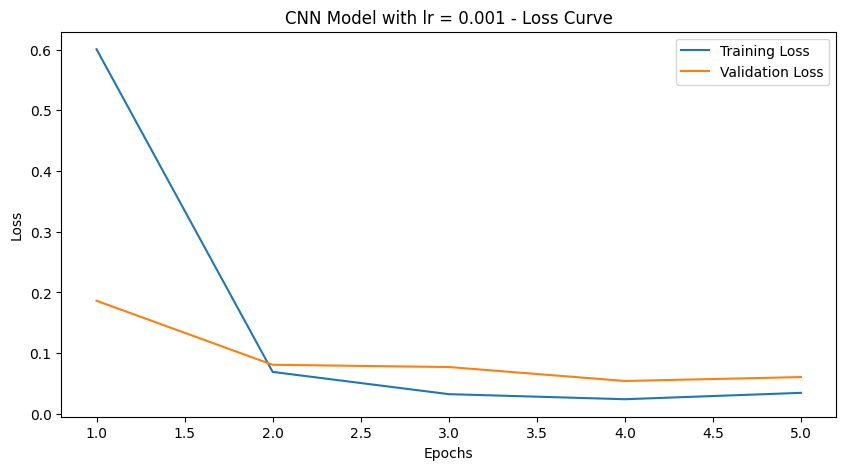

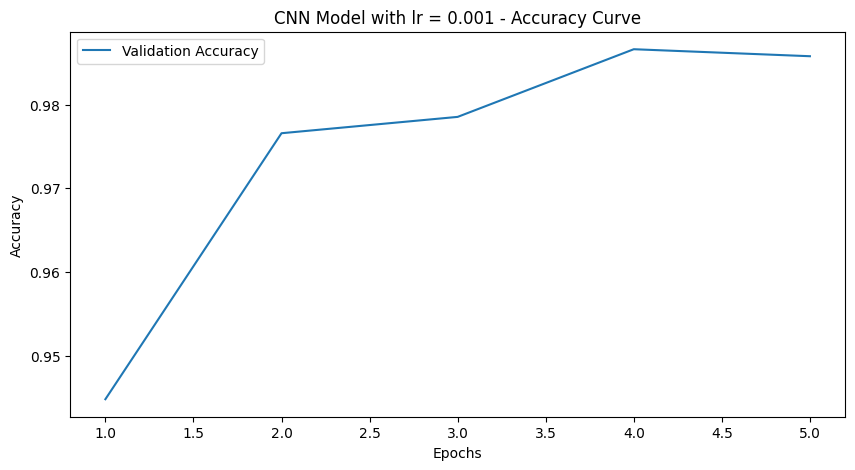

Classification Report:
              precision    recall  f1-score   support

          c0       0.98      0.98      0.98       498
          c1       0.99      1.00      0.99       454
          c2       0.99      0.99      0.99       464
          c3       0.99      0.98      0.99       470
          c4       0.99      0.99      0.99       466
          c5       0.99      1.00      0.99       463
          c6       0.99      0.98      0.99       465
          c7       0.99      0.98      0.98       401
          c8       0.95      0.98      0.97       383
          c9       0.98      0.96      0.97       426

    accuracy                           0.98      4490
   macro avg       0.98      0.98      0.98      4490
weighted avg       0.98      0.98      0.98      4490



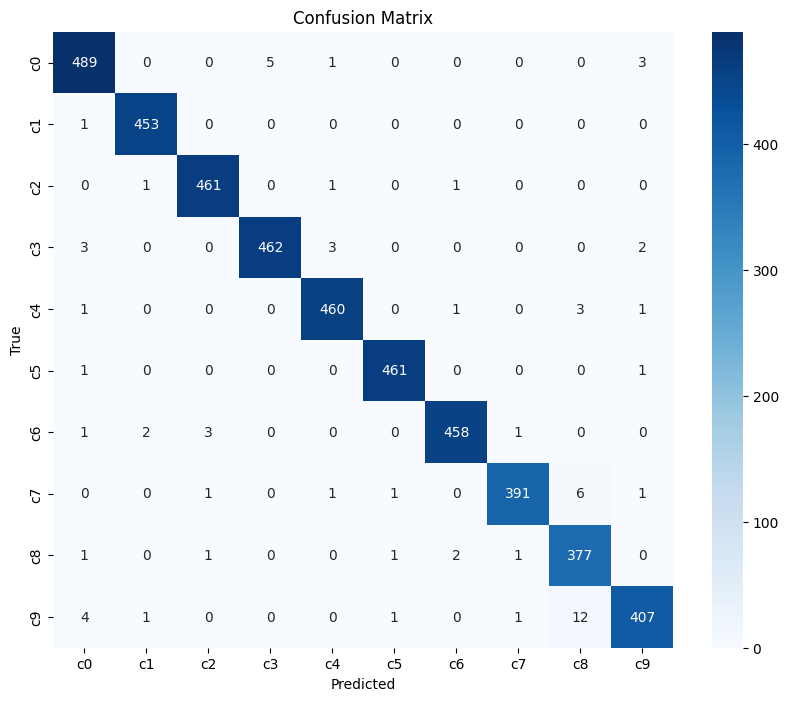

In [13]:
# Train and test CNN Model with lr = 0.001
model1 = CNNmodel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
train_losses, val_losses, val_accuracies = train_model(model1, train_loader, val_loader, criterion, optimizer)
plot_training_results(train_losses, val_losses, val_accuracies, "CNN Model with lr = 0.001")
test_model_with_metrics(model1, test_loader)

Epoch 1/5, Train Loss: 0.9939, Val Loss: 0.2160, Accuracy: 0.9431
Epoch 2/5, Train Loss: 0.1220, Val Loss: 0.1108, Accuracy: 0.9685
Epoch 3/5, Train Loss: 0.0503, Val Loss: 0.0723, Accuracy: 0.9796
Epoch 4/5, Train Loss: 0.0297, Val Loss: 0.0718, Accuracy: 0.9771
Epoch 5/5, Train Loss: 0.0217, Val Loss: 0.0477, Accuracy: 0.9875


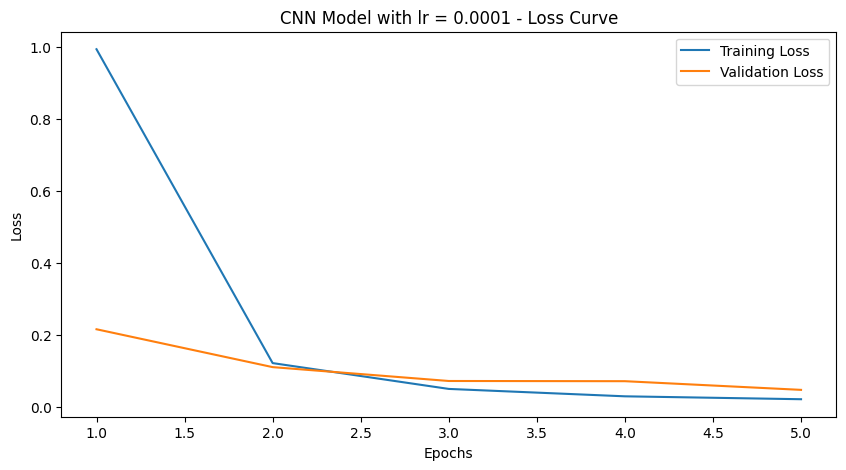

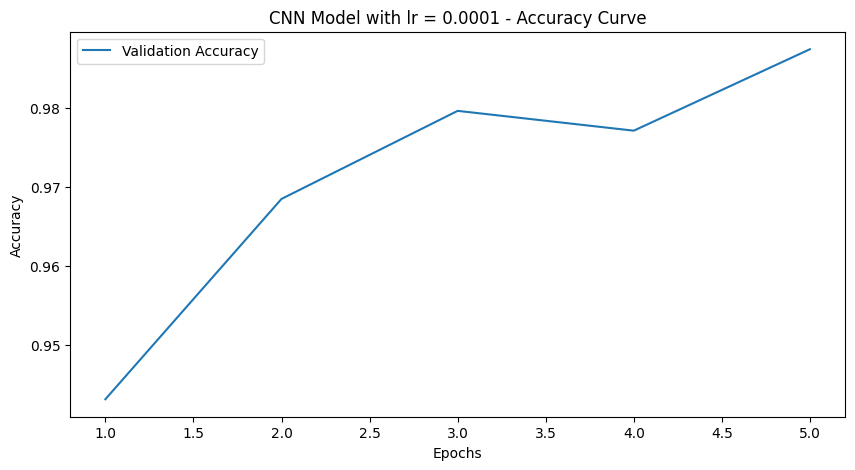

Classification Report:
              precision    recall  f1-score   support

          c0       0.99      1.00      0.99       498
          c1       1.00      0.99      1.00       454
          c2       1.00      0.99      0.99       464
          c3       1.00      0.99      0.99       470
          c4       0.98      1.00      0.99       466
          c5       1.00      0.99      0.99       463
          c6       0.99      0.99      0.99       465
          c7       1.00      1.00      1.00       401
          c8       0.99      0.98      0.98       383
          c9       0.98      0.99      0.98       426

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490



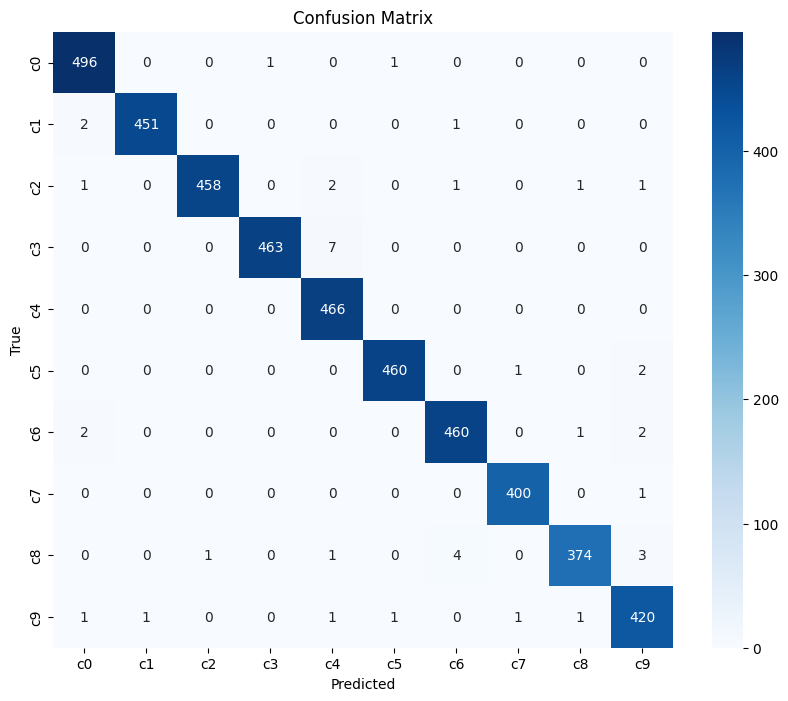

In [14]:
# Train and test CNN Model 1 with lr = 0.0001
model2 = CNNmodel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
train_losses, val_losses, val_accuracies = train_model(model2, train_loader, val_loader, criterion, optimizer)
plot_training_results(train_losses, val_losses, val_accuracies, "CNN Model with lr = 0.0001")
test_model_with_metrics(model2, test_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 35.2MB/s]


Epoch 1/5, Train Loss: 1.3024, Val Loss: 0.8049, Accuracy: 0.8051
Epoch 2/5, Train Loss: 0.7267, Val Loss: 0.6124, Accuracy: 0.8336
Epoch 3/5, Train Loss: 0.5605, Val Loss: 0.4792, Accuracy: 0.8698
Epoch 4/5, Train Loss: 0.4809, Val Loss: 0.4011, Accuracy: 0.8974
Epoch 5/5, Train Loss: 0.4249, Val Loss: 0.4031, Accuracy: 0.8832


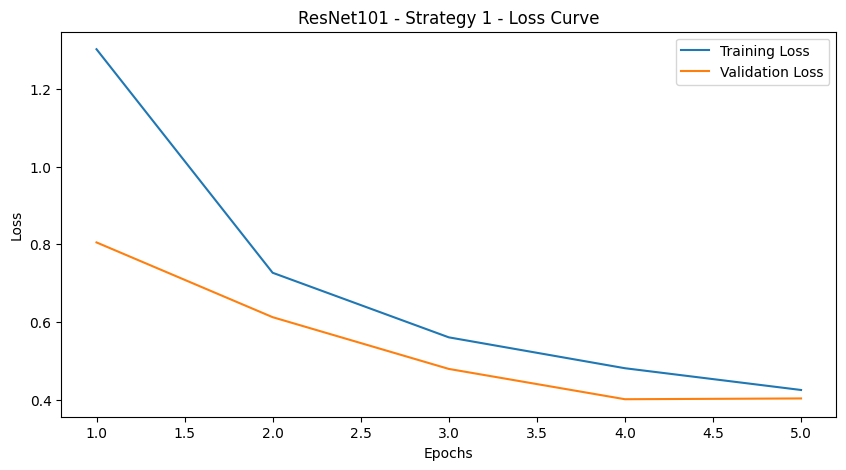

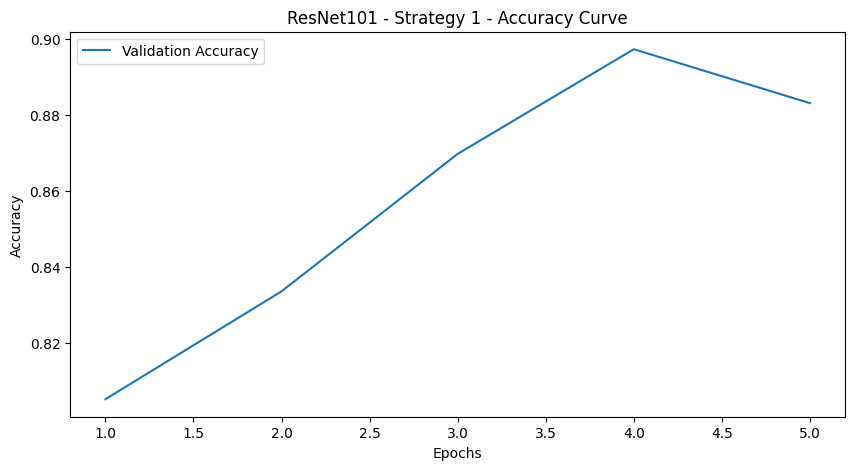

Classification Report:
              precision    recall  f1-score   support

          c0       0.76      0.92      0.84       498
          c1       0.87      0.96      0.91       454
          c2       0.86      0.95      0.90       464
          c3       0.95      0.87      0.91       470
          c4       0.91      0.93      0.92       466
          c5       0.93      0.97      0.95       463
          c6       0.91      0.89      0.90       465
          c7       0.90      0.98      0.94       401
          c8       0.86      0.70      0.77       383
          c9       0.96      0.64      0.77       426

    accuracy                           0.89      4490
   macro avg       0.89      0.88      0.88      4490
weighted avg       0.89      0.89      0.88      4490



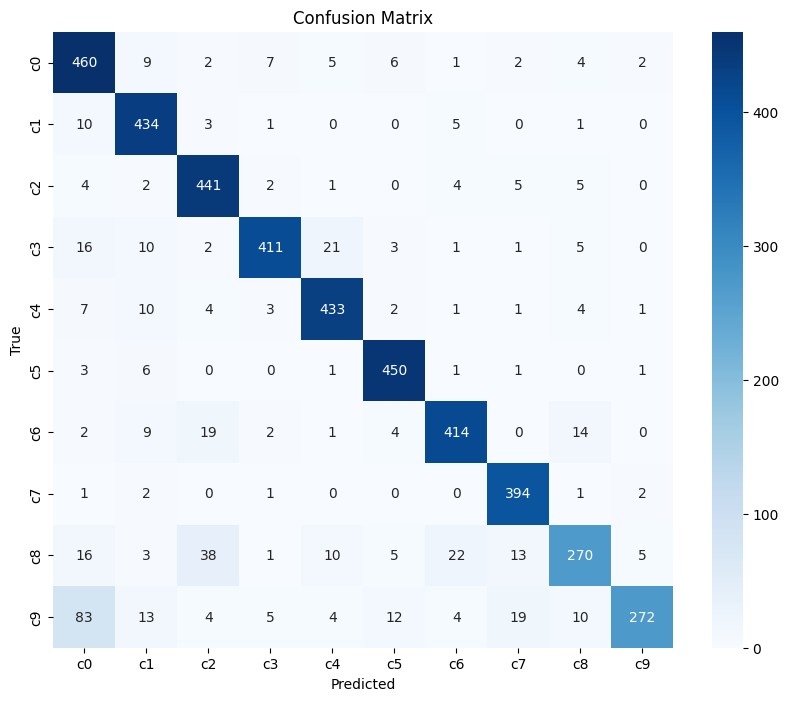

In [15]:
# Train and test ResNet101 Strategy 1
model_resnet1 = resnet_strategy_1()
optimizer_resnet1 = torch.optim.Adam(model_resnet1.parameters(), lr=0.001)
train_losses, val_losses, val_accuracies = train_model(model_resnet1, train_loader, val_loader, criterion, optimizer_resnet1)
plot_training_results(train_losses, val_losses, val_accuracies, "ResNet101 - Strategy 1")
test_model_with_metrics(model_resnet1, test_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.2219, Val Loss: 0.1295, Accuracy: 0.9649
Epoch 2/5, Train Loss: 0.0480, Val Loss: 0.0458, Accuracy: 0.9894
Epoch 3/5, Train Loss: 0.0262, Val Loss: 0.0243, Accuracy: 0.9919
Epoch 4/5, Train Loss: 0.0188, Val Loss: 0.0218, Accuracy: 0.9941
Epoch 5/5, Train Loss: 0.0107, Val Loss: 0.0430, Accuracy: 0.9894


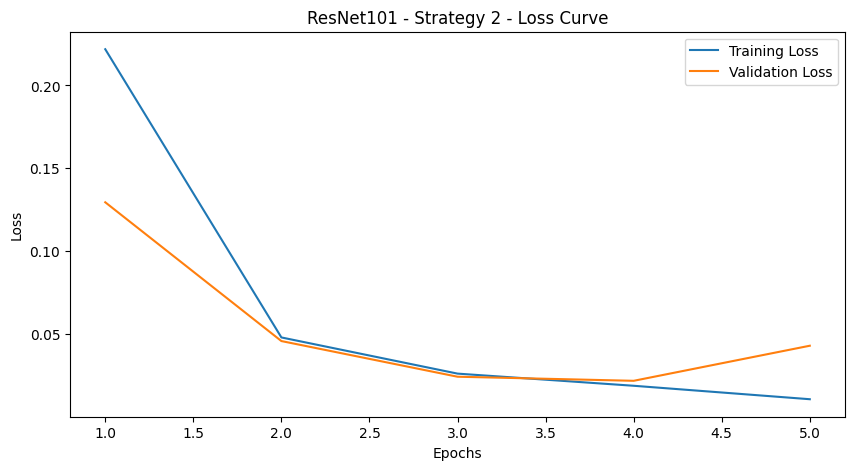

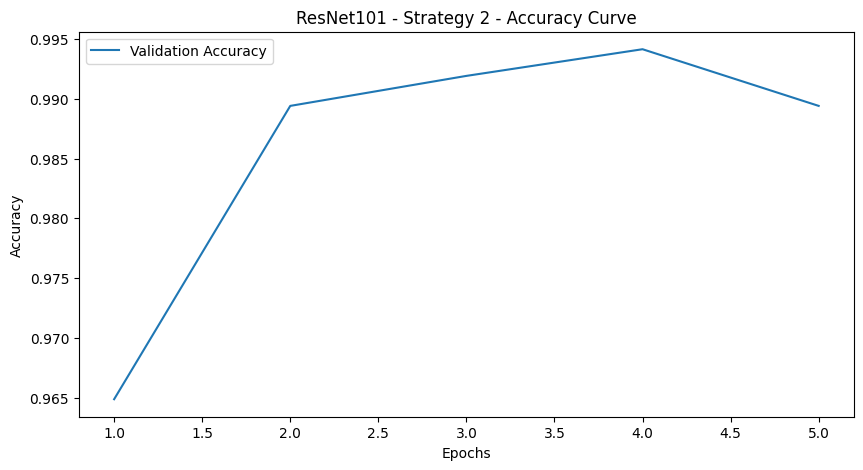

Classification Report:
              precision    recall  f1-score   support

          c0       1.00      0.97      0.98       498
          c1       1.00      1.00      1.00       454
          c2       1.00      1.00      1.00       464
          c3       0.96      1.00      0.98       470
          c4       1.00      0.98      0.99       466
          c5       0.99      1.00      0.99       463
          c6       0.99      1.00      1.00       465
          c7       1.00      1.00      1.00       401
          c8       0.99      0.99      0.99       383
          c9       0.98      0.98      0.98       426

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490



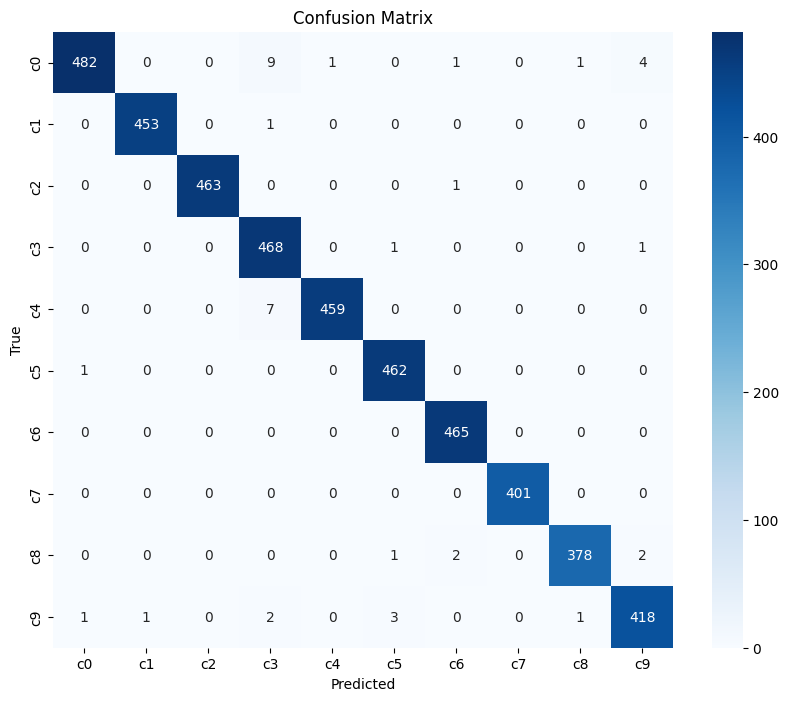

In [16]:
# Train and test ResNet101 Strategy 2
model_resnet2 = resnet_strategy_2()
optimizer_resnet2 = torch.optim.Adam(model_resnet2.parameters(), lr=0.001)
train_losses, val_losses, val_accuracies = train_model(model_resnet2, train_loader, val_loader, criterion, optimizer_resnet2)
plot_training_results(train_losses, val_losses, val_accuracies, "ResNet101 - Strategy 2")
test_model_with_metrics(model_resnet2, test_loader)